In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# Severstal第二步，用于绘制缺陷范围


In [2]:
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
 
# 指定第一块GPU可用 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
 
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 0.3 #定量设置占用30%gpu
config.gpu_options.allow_growth = True  #按需
set_session(tf.Session(config=config)) 

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [3]:
#

import pandas as pd

train_df = pd.read_csv('D:/Selvaria/data/Kaggle/Severstal/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [4]:
import numpy as np

mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [5]:
#test测试集
import pandas

sub_df = pandas.read_csv('D:/Selvaria/data/Kaggle/Severstal/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
sub_df.head()

,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
4,006f39c41.jpg_1,1 1,006f39c41.jpg


In [6]:
test_imgs = pandas.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])#只根据图片名称建表
print(len(test_imgs))
test_imgs.head()

1801


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [7]:
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
print(non_missing_train_idx.shape)
non_missing_train_idx.head()

(6666, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [8]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        #directory=test_path, #目标目录的路径，如果写了要包含在 dataframe 中映射的所有图像
        directory=r'D:/Selvaria\data\Kaggle\Severstal/test_imgs',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False #不打乱顺序
    )


Found 1801 validated image filenames.


In [9]:
from keras.models import Model, load_model

remove_model = load_model('pre_model_2steps_20.h5')
remove_model.summary()

W0922 10:11:21.900004  3796 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 10:11:21.937453  3796 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 10:11:21.963403  3796 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 10:11:21.964399  3796 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0922 10:11:21.964399  3796 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [10]:
test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

#test_imgs['missingCount'] = test_missing_pred.argmax(axis=1) + 1
test_imgs['allMissing'] = test_missing_pred #allMissing列值等于1代表没有给定的缺陷类型，即无缺陷
test_imgs.head()

29/29 [==============================] - 17s 569ms/step


,ImageId,allMissing
0,004f40c73.jpg,0.548148
1,006f39c41.jpg,0.999997
2,00b7fb703.jpg,1.000000
3,00bbcd9af.jpg,0.009755
4,0108ce457.jpg,1.000000


In [11]:
filtered_test_imgs = test_imgs[test_imgs['allMissing'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(610, 2)


,ImageId,allMissing
3,00bbcd9af.jpg,0.009755
6,010ec96b4.jpg,0.360921
9,01b47d973.jpg,0.002467
18,037e7564c.jpg,0.322336
19,0384b28ff.jpg,0.017914


In [12]:
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()

null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(lambda x: ' ')

# filtered_sub_df['ImageId'] = filtered_sub_df['ImageId'].apply(
#     lambda x: x.replace('.png', '.jpg'))
# filtered_test_imgs['ImageId'] = filtered_test_imgs['ImageId'].apply(
#     lambda x: x.replace('.png', '.jpg'))

filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

(2440, 3)
(4764, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,1 1,00bbcd9af.jpg
1,00bbcd9af.jpg_2,1 1,00bbcd9af.jpg
2,00bbcd9af.jpg_3,1 1,00bbcd9af.jpg
3,00bbcd9af.jpg_4,1 1,00bbcd9af.jpg
4,010ec96b4.jpg_1,1 1,010ec96b4.jpg


In [13]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    
    starts = starts - 1

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

print(train_df.loc[0,'EncodedPixels'])
mask_tensor = rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))
print(mask_tensor, mask_tensor.shape)
print(mask2rle(rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))))
mask2rle(rle2mask('1 1',((256,1600,1))))

29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5
[[0 0 0 ... 0 

'1 1'

In [14]:
from skimage.color import gray2rgb
import keras
import cv2

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='D:/Selvaria/data/Kaggle/Severstal/train_imgs',
                 batch_size=32, dim=(256, 1600), n_channels=3,
                 n_classes=4, random_state=2019, shuffle=True,aug=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.seq = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
                
        X = self.__generate_X(list_IDs_batch)
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y.astype(int)
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = gray2rgb(img[:,:,0])

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [17]:
from keras import backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [21]:
BATCH_SIZE = 2
import imgaug as ia
import imgaug.augmenters as iaa

from keras.models import Sequential
from sklearn.model_selection import train_test_split

seq = iaa.Sequential([
    iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Fliplr(),
    iaa.Flipud(),
    iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
], random_order=True)


train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # NOTICE DIFFERENCE
    random_state=1949, 
    test_size=0.15
)

In [24]:
print(train_idx.shape)
print(train_df.shape)

(5666,)
(50272, 5)


In [25]:
train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

In [39]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inputs = Input((256, 1600, 3)) #原图尺寸，黑白单通道

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5) #到这里一直是在对原始的input进行层操作变换

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5) #开始对原始的input进行变换，直到u6的反向卷积
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

#应该是使用了残差连接，用于避免梯度消失和表示瓶颈
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55) #转置卷积层 (有时被成为反卷积)，将具有该卷积层输出shape的tensor转换为具有该卷积层输入shape的tensor。同时保留与卷积层兼容的连接模式
u6 = concatenate([u6, c5]) #和上一步在一起，相当于降维后连结在一起，和之前的维度相同。默认axis=-1(最后一个轴)，相当于按照c5[-1轴],u6[-1轴]拼接，即
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])#使用之前写的评分函数
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 1600, 8) 224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 1600, 8) 584         conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

In [37]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

preprocess = get_preprocessing('resnet34')
model = Unet('resnet34', input_shape=(256, 1600, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

85524480/85521592 [==============================] - ETA: 10 - ETA: 13:3 - ETA: 11:3 - ETA: 7:0 - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 50s - ETA: 54 - ETA: 43 - ETA: 35 - ETA: 30 - ETA: 27 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

stage1_unit3_relu1 (Activation) (None, 64, 400, 64)  0           stage1_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_43 (ZeroPadding2 (None, 66, 402, 64)  0           stage1_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_conv1 (Conv2D)     (None, 64, 400, 64)  36864       zero_padding2d_43[0][0]          
__________________________________________________________________________________________________
stage1_unit3_bn2 (BatchNormaliz (None, 64, 400, 64)  256         stage1_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_relu2 (Activation) (None, 64, 400, 64)  0           stage1_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_paddi

stage2_unit4_conv1 (Conv2D)     (None, 32, 200, 128) 147456      zero_padding2d_51[0][0]          
__________________________________________________________________________________________________
stage2_unit4_bn2 (BatchNormaliz (None, 32, 200, 128) 512         stage2_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu2 (Activation) (None, 32, 200, 128) 0           stage2_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_52 (ZeroPadding2 (None, 34, 202, 128) 0           stage2_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit4_conv2 (Conv2D)     (None, 32, 200, 128) 147456      zero_padding2d_52[0][0]          
__________________________________________________________________________________________________
add_23 (Ad

stage3_unit4_relu2 (Activation) (None, 16, 100, 256) 0           stage3_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_60 (ZeroPadding2 (None, 18, 102, 256) 0           stage3_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv2 (Conv2D)     (None, 16, 100, 256) 589824      zero_padding2d_60[0][0]          
__________________________________________________________________________________________________
add_27 (Add)                    (None, 16, 100, 256) 0           stage3_unit4_conv2[0][0]         
                                                                 add_26[0][0]                     
__________________________________________________________________________________________________
stage3_unit5_bn1 (BatchNormaliz (None, 16, 100, 256) 1024        add_27[0][0]                     
__________

stage4_unit2_conv2 (Conv2D)     (None, 8, 50, 512)   2359296     zero_padding2d_68[0][0]          
__________________________________________________________________________________________________
add_31 (Add)                    (None, 8, 50, 512)   0           stage4_unit2_conv2[0][0]         
                                                                 add_30[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_bn1 (BatchNormaliz (None, 8, 50, 512)   2048        add_31[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_relu1 (Activation) (None, 8, 50, 512)   0           stage4_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_69 (ZeroPadding2 (None, 10, 52, 512)  0           stage4_unit3_relu1[0][0]         
__________

                                                                 relu0[0][0]                      
__________________________________________________________________________________________________
decoder_stage3_conv1 (Conv2D)   (None, 128, 800, 32) 36864       concatenate_12[0][0]             
__________________________________________________________________________________________________
decoder_stage3_bn1 (BatchNormal (None, 128, 800, 32) 128         decoder_stage3_conv1[0][0]       
__________________________________________________________________________________________________
decoder_stage3_relu1 (Activatio (None, 128, 800, 32) 0           decoder_stage3_bn1[0][0]         
__________________________________________________________________________________________________
decoder_stage3_conv2 (Conv2D)   (None, 128, 800, 32) 9216        decoder_stage3_relu1[0][0]       
__________________________________________________________________________________________________
decoder_st

In [38]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

#model = load_model('D:/Selvaria/data/Kaggle/Severstal/model_unet18_2steps.h5')

checkpoint = ModelCheckpoint(
    'D:/Selvaria/data/Kaggle/Severstal/model_unet18_2steps.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau( #自动减小学习率的回调函数，默认facor=0.1
    monitor='val_loss',
    patience=4, #当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
    verbose=2,
    min_lr=1e-6 #下限
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=25
)

Epoch 1/25
 113/2833 [>.............................] - ETA: 8:52:57 - loss: 0.7629 - dice_coef: 0.03 - ETA: 4:31:08 - loss: 0.7245 - dice_coef: 0.01 - ETA: 3:03:44 - loss: 0.6993 - dice_coef: 0.02 - ETA: 2:20:04 - loss: 0.6724 - dice_coef: 0.02 - ETA: 1:53:51 - loss: 0.6497 - dice_coef: 0.03 - ETA: 1:36:21 - loss: 0.6261 - dice_coef: 0.02 - ETA: 1:23:53 - loss: 0.6050 - dice_coef: 0.03 - ETA: 1:14:31 - loss: 0.5873 - dice_coef: 0.02 - ETA: 1:07:13 - loss: 0.5686 - dice_coef: 0.02 - ETA: 1:01:24 - loss: 0.5513 - dice_coef: 0.02 - ETA: 56:37 - loss: 0.5352 - dice_coef: 0.0217 - ETA: 52:39 - loss: 0.5204 - dice_coef: 0.01 - ETA: 49:17 - loss: 0.5063 - dice_coef: 0.01 - ETA: 46:24 - loss: 0.4938 - dice_coef: 0.01 - ETA: 43:55 - loss: 0.4836 - dice_coef: 0.01 - ETA: 41:43 - loss: 0.4728 - dice_coef: 0.01 - ETA: 39:47 - loss: 0.4614 - dice_coef: 0.01 - ETA: 38:05 - loss: 0.4505 - dice_coef: 0.01 - ETA: 36:32 - loss: 0.4406 - dice_coef: 0.01 - ETA: 35:10 - loss: 0.4308 - dice_coef: 0.01 - ET

KeyboardInterrupt: 

In [30]:
model.save('D:/Selvaria/data/Kaggle/Severstal/model_unet18_2steps.h5')

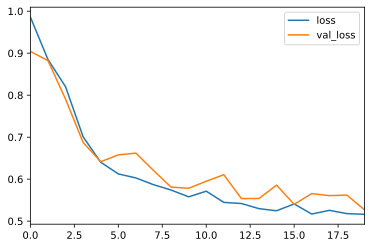

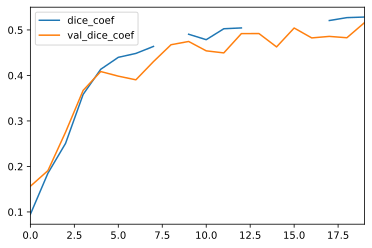

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

history_df = pandas.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [34]:
import gc
from tqdm import tqdm
from keras.models import load_model

gc.collect()

model.load_weights('D:/Selvaria/data/Kaggle/Severstal/model_unet18_2steps.h5')
#model = load_model('D:/data/Kaggle/Severstal/model_2.1.h5')
test_df = []

for i in range(0, filtered_test_imgs.shape[0], 200):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 200))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='D:/Selvaria/data/Kaggle/Severstal/test_imgs',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=0,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int) #round()是numpy的函数，是将张量内的所有元素五舍六入到整数
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

200it [00:11, 16.99it/s]
200it [00:12, 17.76it/s]
200it [00:12, 16.17it/s]
10it [00:00, 16.83it/s]


In [35]:
test_df = pandas.concat(test_df)
print(test_df.shape)
test_df.head()

(2440, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,306605 3 306860 6 307116 8 307371 13 307627 14...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,010ec96b4.jpg_1,,010ec96b4.jpg


In [36]:
final_submission_df = pandas.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head(20)

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,00bbcd9af.jpg_1,,00bbcd9af.jpg
1,00bbcd9af.jpg_2,,00bbcd9af.jpg
2,00bbcd9af.jpg_3,306605 3 306860 6 307116 8 307371 13 307627 14...,00bbcd9af.jpg
3,00bbcd9af.jpg_4,,00bbcd9af.jpg
4,010ec96b4.jpg_1,,010ec96b4.jpg
5,010ec96b4.jpg_2,,010ec96b4.jpg
6,010ec96b4.jpg_3,37602 11 37856 16 38109 21 38357 36 38553 14 3...,010ec96b4.jpg
7,010ec96b4.jpg_4,,010ec96b4.jpg
8,01b47d973.jpg_1,,01b47d973.jpg
9,01b47d973.jpg_2,,01b47d973.jpg


In [78]:
for index in final_submission_df.index:
    e_pixels = str(final_submission_df['EncodedPixels'].iloc[index])
    if len(e_pixels)>1 and len(e_pixels)< 4:
        print(e_pixels)
print('check end')

check end


In [79]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('D:/data/Kaggle/Severstal/submission_2.csv', index=False)